In [12]:
from IPython.display import Image

Reference: [Mol. Pharmaceutics, 2018, 15 (10), pp 4398–4405](https://www.ncbi.nlm.nih.gov/pubmed/30180591)

이 논문에서 다루는 모델의 이름은 Entangled Conditional Adversarial AutoEncoder(ECAAE)이다. 해석하자면 정보가 섞인(entangled) 조건에 대한(conditional) Adversarial AutoEncoder이다. 좀 더 깊게 들어가보기 전에, Adversarial AutoEncoder(AAE)가 무엇인지 [이곳]()의 설명을 보고 넘어가자. 요약하자면, AAE는 Autoencoder에 Generative Adversarial Network(GAN)을 붙인 모델로, prior와 posterior의 분포 모형으로 정규분포만을 가정할 수 있는 VAE에서, 특정 확률 분포 모델로 고정될 필요가 없는 GAN을 이어붙이면서 다양한 데이터 분포를 예측할 수 있게 한 모델이다.
일반적인 Conditional Adversarial Autoencoder(CAAE)은 [AAE의 논문](https://arxiv.org/abs/1511.05644)에서 소개된 Supervised Adversarial AutoEncoder(SAAE)라고 보면 된다. MNIST로 설명을 하자면, 0부터 9까지의 손글씨에 대한 라벨링을 추가적으로 latent vector $z$에 해준다는 것이다. 다만 이 과정에서 latent vector $z$가 Autoencoder의 Generator에 의해 data $x$로 복원이 될 때 one-hot vector과 같은 방식으로 property $y$에 대한 라벨링이 추가되는 것이다. 보통의 AAE의 loss funciton의 optimization은 다음과 같다. 여기서 앞쪽 두 개의 항은 regularization term으로 GAN의 loss라고 생각하면 되고, 마지막 항은 reconstruction term으로 AE의 loss라고 생각하면 된다.  
$\ \  \quad \qquad \qquad min_{E,G} max_D L_{adv}$
$$= min_{E,G} max_D E_{x \sim p_{data}} log D(E(x)) + E_{z \sim p_{(z)}} log (1 - D(z)) - E_{x \sim p_{data}} log p(x|G(E(x)))$$
CAAE(SAAE)의 경우, 다음과 같이 property $y$에 대한 정보가 reconstruciton할 때 포함되어야 하기 때문에 reconstruction 항에 $y$가 함께 들어간다.  
$\ \  \quad \qquad \qquad min_{E,G} max_D L_{adv}$
$$= min_{E,G} max_D E_{x \sim p_{data}} log D(E(x)) + E_{z \sim p_{(z)}} log (1 - D(z)) - E_{x \sim p_{data}} log p(x|G(E(x), y))$$

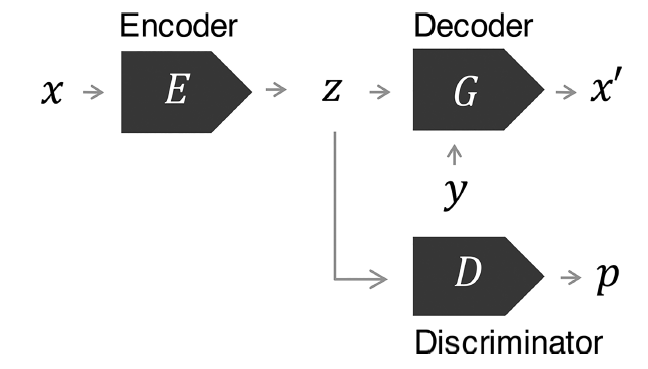

In [13]:
Image(filename = '../img/CAAE.png')

이론적으로 데이터 $x$가 property $y$에 모두 매핑되어 있으면, 모든 $y$에 대해 $p(x|y)$로 어떤 $x$든지 재생성 가능하다. 하지만 위의 그림과 같이 설계를 한다면, latent vector $z$를 만들고, property $y$를 추가한 다음 데이터 $x'$를 재생성하는 것이기 때문에 분자의 구조 등을 나타낼 수 있는 $z$와 $y$사이의 연관성이 없어지게 된다. 직관적으로 생각해보았을 때 아래의 그림과 같이 $p(z)$가 전체 latent code로써 존재하더라도, $y$에 따라 $p(z|y)$가 완전히 다르게 나온다면 특정한 $y$가 주어졌을 때 $p(z)$로 데이터를 재생성할 수 없을 것이다. 그럴 경우 다른 모든 것들이 제대로 작동하더라도 샘플링이 일관되지 않을 수 있다. 논문에서는 기존의 SAAE에서 condition을 넣어주는 방식 때문에 샘플링이 일관되지 않는 문제를 극복하기 위해 논문에서는 두 가지 방법을 제시한다.
1. Conditional Distribution $p(z|y)$를 marginal distribution $p(z)$에 근사시킨다.
2. $p(z|y)$를 직접적으로 학습시킨다.

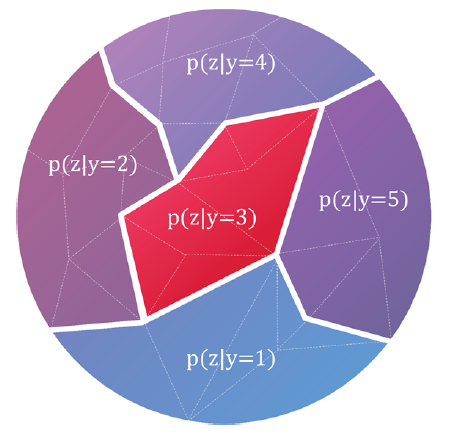

In [14]:
Image(filename = '../img/Motivation_of_Disentanglement.png')

### Disentanglement of Z and Y
Latnet code $z$와 property $y$를 분리시키는 법에 대한 내용이다.
#### Predictive Disentanglement
우선 두 가지 random variable 사이의 관계를 유추하기 위해서 우리는 다음과 같은 mutual information이라는 항을 정의할 수 있다.
$$I(z,y) = KL[p(z,y)||p(z)p(y)] = \int p(z,y)log \frac {p(z,y)}{p(z)p(y)} dzdy$$
$KL$은 Kullback-Leibler divergence로, 두 distribution의 유사도를 알아낼 수 있다. KL divergence 값이 작아질 수록 두 distribution이 유사한 것인데 이를 통해 mutual information값이 작아질 수록 $p(z,y) = p(z \cap y)$가 $p(z)p(y)$와 비슷해진다는 것을 알 수 있고 이는 $z$와 $y$가 independent하다는 것을 말한다.
$$I(z, y) = H(y) + E_{p(y,z)} log\ p(y|z) + max_q -E_{p(z)}KL(p(y|z)||q(y|z))$$
$$= H(y) + max_q E_{p(y,z)} log\ q(y|z) \qquad \qquad \qquad \qquad$$
위와 같은 식변형을 통해 $I(z,y)$를 정리할 수 있고, $H(y)$는 여기서 constant entropy term을, $q$는 $p(y|z)$를 유추하기 위해서 학습되는 neural network이다. 상수항은 regularizing 단계에서 필요하지 않으므로, 우리가 optimize 해야할 것은 아래와 같이 표현된다.
$$R_{predictive} = max_{q(y|E(x))} E_{(x,y) \sim p_{data}} log\ q(y|E(x))$$
처음에는 $q$가 $z$로부터 property $y$를 뽑아내도록 학습을 시킨 다음, encoder를 $z$에서 $y$가 없게 만들게끔 학습시킨다. 좀 더 풀어서 말하자면, 우리가 보통 prediction 문제를 풀고자 할때는 target distribution과 유사하게 만들어지는 방향으로 학습을 시키지만, 여기에서는 latent code $z$로부터 property $y$를 제대로 예측할 수 없게끔 하여 $y$에 대한 정보를 담지 않는 latent code $z$를 만들게 하는 방향으로 encoder를 학습시키는 것이다. 아래의 그림에서는 빨간색 선이 $z$로부터 $y$를 뽑아내도록 학습시키는 부분, 파란색 부분이 $z$를 추출한 $y$를 없애도록 학습시키는 부분이다. 이를 통해 encoder는 property와 상관 없는, disentanglement한 latent code를 만들어내게 된다.

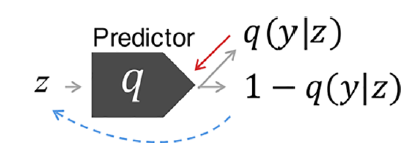

In [15]:
Image(filename = '../img/Predictive_Disentanglement.png')

#### Joint Disentanglement
Predictive model은 보통 $y$성분들 간의 연관성이 없다고 가정하여 각 성분에 대해 model을 optimize시킬 수 있다. 식으로 표현하자면 $q(y_i|z) = p(y_i)$처럼, $z$에 대해서만 연관 없는 marginal distribution을 만든다고 보면 된다. 하지만 이는 joint independence를 나타내지는 않는다(참고로, joint independence는 A,B,C 세 가지의 변수가 있어 A,B사이에 관계가 있고, A,C와 B,C사이엔 관계가 없을 때 C가 jointly independent of A, B라고 한다). 논문에서의 경우엔 $q(y|z) = p(y)$를 뜻하지 않는다는 것이다. 논문에서는 $z$와 $y$를 독립시켜 생각하였고, prior로써 이 가정을 나타내는 $p(z)p(y)$를 사용하였다. $q(E(x),y))$를 이것에 맞춰 adversarial training을 시키면 $z(=E(x))$, $y$가 결국 independent해질 것이라는 주장이다. 실제 model은 아래의 그림과 같다. $\epsilon$은 0과 1사이의 난수이며 그림에서 말하고자 하는 바는 임의의 난수 $\epsilon$과 property $y$는 관계가 없고, latent code $z$와 property $y$는 어느 정도의 상관관계가 있을 것이기 때문에 이를 통해서 구분을 하고, discriminator가 잘 구분하지 못하도록 하기 위해서 encoder는 또다시 property $y$와 관계가 없는 latent code $z$를 만들도록 학습을 하게 되는 것이다.

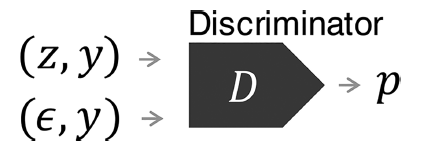

In [16]:
Image(filename = '../img/Joint_Disentanglement.png')

Predictive/Joint disentanglement를 모두 사용하면 predictive disentanglement는 각 property들의 independence를 강조시키고, joint disentanglement는 나머지 mutual information을 감소시키는, 전체적인 independence를 증가시킨다고 한다.

### Entangled Representaiton
Latent code와 label을 독립시켜 처리하는 것은 좋은 방법이긴 하나 문제점이 있다. 제약 분야에서 분자를 분석할 때 분자량(MW)과 극성 표면적(TPSA)은 거의 비슷한 경향을 보인다. 이러한 비슷한 성질들을 처리할 때 개중 하나의 label을 독립시킨다면 다른 label들이 영향을 받을 수도 있다. 이를 개선하기 위해 논문에서는 $y$와 $z$의 연관성을 추가시켜주었다.  
$p(z|y) = N(z|\mu_\theta (y), \Sigma_\theta (y)$를 $\theta$ 하나의 parameter만 가지는 multivate normal distribution으로 학습시키면서 discriminator로 하여금 $q(E(x)|y)$와 $N(z|\mu(y), \Sigma(y))$를 구분하도록 학습시켰다. 하지만 이렇게 학습을 거칠 경우, $y$에 대한 정보가 거의 없을 경우 학습에 문제가 생기고, 두 개의 학습 가능한 분포에 대해서 discrimination을 거치는 것은 unstable하다. 그렇기 때문에 reparametrization trick을 거쳐 $\bar{z} = g_\theta (z,y), g_\theta (z,y) = \Sigma_\theta^{-1/2} y(z -\mu_\theta (y))$로 표현을 하여 $p(\bar{z})p(y)$와 $q(g_\theta (E(x),y),y)$를 discrimination하도록 학습시킨다. 여기서, $\bar{z}$를 만드는 과정에서 이미 $y$의 정보가 들어가기 때문에 $\bar{z}$자체로 entangled representation이라고 볼 수 있고, 그것을 다시 joint disentanglement를 취해준 것이 위의 결과이다. 여기에서 predictive disentanglement까지 추가해준다면 최종적인 ECAAE model이 완성되는 것이다.

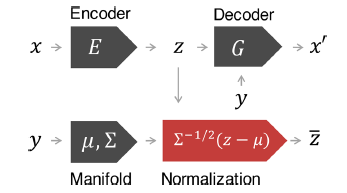

In [17]:
Image(filename = '../img/Entangled_Model.png')

데이터 $x$는 encoder를 통해서 latent code $z$로 바뀐다. $z$는 normalize distribution과 reparameterization trick을 거쳐 property $y$를 포함하는 entangled representation $\bar{z}$가 되고, 이것을 위에서 언급하였던 두 가지 disentanglement를 거쳐서 남은 property $y$와 $z$가 연관되지 않게끔 encoder를 학습시킨다. 그렇게 해서 나온 $z$를 $y$와 함께 decoding시켜 최종적인 $x'$을 만들어내는 것이다.  
마지막으로 최종적인 loss function은 다음과 같이 표현된다.
$$min_{E,G,\theta} max_{D, q} E_{(x, y) \sim p_{data}} log D(g_\theta (E(x),y), y) + E_{y \sim p_{(y)}}E_{\bar{z} \sim p_{(\bar{z})}} log (1 - D(\bar{z}, y)) \qquad \qquad \quad - E_{(x, y) \sim p_{data}} log p(x|G(E(x), y)) + \lambda E_{(x,y) \sim P_{data}} log q(y|g_\theta (E(x), y))$$

덧붙이자면, $\lambda$가 있는 항이 predictive disentanglement 두 번째 항의 $E_{y \sim p(y)}$가 joint disentanglement를 나타내고, $\bar{z}$를 통해서 이미 entangled representation은 표현이 되었고 앞의 두 가지 항은 adversarial net의 regularization term이다. 마지막으로 세 번째 항은 autoencoder의 reconstruction term이다.